In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tifffile

In [2]:
WORKDIR='/home/daniel/gdrive/EPFL/2019-2020/MachineLearning/Project/gravitational_lens_ml'
SRC = os.path.join(WORKDIR, 'src')
DATA = os.path.join(WORKDIR,'data')
RESULTS = os.path.join(WORKDIR, 'results')
TRAIN = os.path.join(DATA, 'datapack2.0train/Public')
TEST = os.path.join(DATA, 'datapack2.0test/Public')

In [3]:
image_catalog = pd.read_csv(os.path.join(DATA, 'catalog/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [4]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [5]:
band = 'EUC_VIS'
def get_file_id(filename, band):
    return filename.replace('image%s-'%band,'').replace('.fits', '')
file_id_train = np.array([get_file_id(f, band) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
file_id_test = np.array([get_file_id(f, band) for f in os.listdir(os.path.join(TEST, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
print(np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False))

[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [6]:
check_existing_files('EUC_H', TRAIN)

File imageEUC_H-213913.fits does not exist in set.
File imageEUC_H-226305.fits does not exist in set.
File imageEUC_H-233597.fits does not exist in set.
File imageEUC_H-244071.fits does not exist in set.
File imageEUC_H-259871.fits does not exist in set.
File imageEUC_H-261145.fits does not exist in set.
File imageEUC_H-270458.fits does not exist in set.
File imageEUC_H-288731.fits does not exist in set.
File imageEUC_H-294173.fits does not exist in set.


In [7]:
for key,gr in image_catalog.groupby('ID'):
    if gr.shape[0] > 1:
        print(key)
        display(gr)

210000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
7701,210000,2.147660e-07,-6.692130e-08,4397,2.37,1.113780,26.6560,4.463020e-10,16,0.000005,...,6.048030e-02,3.18182,1,2,5,5.703140e+13,1.111090e+12,21.7341,1,True
179,210000,8.702270e-09,9.202760e-09,2612,4.36,0.380968,26.2732,9.719720e-10,8,0.000015,...,-1.000000e+130,1.74287,0,0,4,1.322080e+14,9.087010e+11,18.2317,0,False


220000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
7172,220000,3.812780e-08,3.007720e-07,747,2.84,1.18233,25.5157,3.558160e-10,22,0.000005,...,0.113513,3.08559,1,4,7,2.678640e+13,6.196280e+11,22.8561,1,True
9140,220000,-1.584600e-07,7.572220e-08,3354,2.22,1.07812,26.7890,1.870110e-10,16,0.000007,...,0.123142,3.14586,1,2,6,3.109840e+13,5.991420e+11,22.5029,1,True


230000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
7215,230000,1.049820e-07,-4.398410e-07,6920,1.52,0.628204,27.4774,8.250330e-10,23,0.000018,...,0.743276,1.31523,2,5,14,1.106690e+14,5.013430e+11,20.0833,1,True
4836,230000,4.229010e-07,1.617360e-07,7453,2.89,1.045290,25.5464,2.205680e-10,21,0.000002,...,0.243123,1.96259,0,0,2,2.022150e+13,5.640060e+11,22.3048,1,True


240000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
3960,240000,8.716460e-09,1.346290e-07,5406,1.54,1.169850,26.991,2.195620e-10,20,0.000003,...,1.73769,2.78630,1,2,4,4.733680e+13,5.195410e+11,22.4862,1,True
8328,240000,1.167460e-07,4.585980e-07,1479,2.34,0.528561,26.919,1.506530e-10,18,0.000001,...,8.63243,1.20511,0,3,6,1.360400e+13,4.988540e+11,19.4943,1,True


250000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
564,250000,-2.642000e-07,7.511860e-08,3768,4.64,1.299010,25.3512,6.049720e-10,13,0.000011,...,0.025262,1.57795,2,3,5,4.964280e+13,6.163380e+11,22.2403,1,True
2038,250000,-3.198310e-07,-1.931600e-07,6805,2.88,0.770704,27.0679,6.251630e-10,18,0.000013,...,0.193436,1.31487,2,5,9,4.808240e+13,5.084010e+11,20.8287,1,True


260000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
9215,260000,3.867250e-07,1.098860e-07,2730,2.68,1.031090,27.8325,1.299330e-10,14,0.000006,...,0.178349,2.89788,0,0,0,1.178920e+13,5.792250e+11,22.2298,1,True
359,260000,-4.289610e-07,5.061270e-08,1222,4.72,0.483388,26.3977,3.404010e-10,8,0.000002,...,1.557000,2.08263,1,1,2,2.037040e+13,4.742720e+11,19.2337,1,True


270000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
1718,270000,-1.168860e-08,-3.034550e-08,4118,3.69,0.376323,26.8497,5.422650e-10,10,0.000004,...,3.055830,1.69199,0,2,4,2.280420e+13,3.952550e+11,18.7059,1,True
3925,270000,1.587690e-07,1.457520e-07,349,2.35,0.684567,27.8710,1.733620e-09,39,0.000004,...,0.047699,2.19924,2,2,8,4.105040e+14,1.151740e+12,19.2821,1,True


280000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
6698,280000,1.947370e-07,3.006300e-07,9869,2.68,1.775240,25.5129,9.486970e-11,26,0.000002,...,0.263969,2.30037,0,0,6,2.303920e+13,5.579210e+11,24.3634,1,True
7801,280000,7.074440e-08,-1.274980e-07,8430,2.02,0.949903,27.8342,1.299310e-10,8,0.000005,...,0.921605,2.00211,2,2,3,1.298280e+13,4.017180e+11,21.5535,1,True


290000


,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,sb_contrast,color_diff,n_gal_3,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,is_lens
5775,290000,-1.168620e-07,-3.376720e-07,5127,2.29,0.530445,25.4576,8.072890e-10,20,0.000005,...,1.596850,0.480088,0,2,7,3.559370e+13,9.687080e+11,18.8773,1,True
3665,290000,2.891580e-07,9.659280e-08,9475,2.30,1.196310,27.0087,1.418600e-10,10,0.000004,...,0.206522,2.707170,0,1,2,1.665640e+13,7.443910e+11,22.3640,1,True


In [8]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [9]:
def get_image_filename_from_id(id_, band, set_ = TRAIN):
    fname = os.path.join(set_, '{0}/image{0}-{1}.fits'.format(band, id_))
    return fname
def plot_all_bands_from_id(id_):
    fig = plt.figure(figsize=(20, 6))
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(aplpy.FITSFigure(data[i], figure=fig, subplot=(1,4,i+1)))
        fitsfigs[i].show_colorscale()
        fitsfigs[i].set_theme('preety')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()
    fig.tight_layout() 
with fits.open(get_image_filename_from_id(290000, 'EUC_VIS')) as hdu1:
    with fits.open(get_image_filename_from_id(290000, 'EUC_H')) as hdu2:
        data1 = hdu1[0].data
        data2 = hdu2[0].data
        data2_reprojected, data2_footprint = reproject_interp(hdu2[0], hdu1[0].header)


/home/daniel/anaconda3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -2.799e-12 [aplpy.core]
INFO: Auto-setting vmax to  1.386e-11 [aplpy.core]


INFO: Auto-setting vmin to -1.236e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.096e-09 [aplpy.core]


INFO: Auto-setting vmin to -8.179e-11 [aplpy.core]
INFO: Auto-setting vmax to  6.074e-10 [aplpy.core]


INFO: Auto-setting vmin to -1.043e-10 [aplpy.core]
INFO: Auto-setting vmax to  8.215e-10 [aplpy.core]


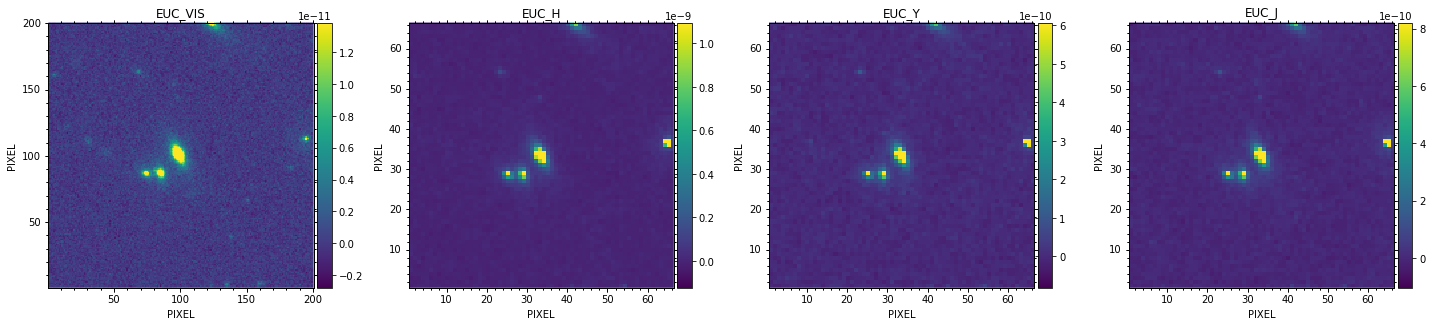

In [11]:
plot_all_bands_from_id(270610)

In [249]:
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval

def build_image(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        interval = AsymmetricPercentileInterval(0.25, 99.75, n_samples=10000)
        vmin, vmax = interval.get_limits(band_data)
        stretch = MinMaxInterval() +  LogStretch()
        print(vmax, vmin)
        data[:,:,i] = stretch(((np.clip(band_data, -vmin*0.7, vmax))/(vmax)))
    for t in tables:
        t.close()
    return data


1.968410618530267e-11 -1.426535635494844e-12
1.4441427535575332e-09 -1.7959529408677333e-11
1.2880838848939581e-09 -2.1217583308305794e-11
7.443535462431848e-10 -2.0070244378801077e-11
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


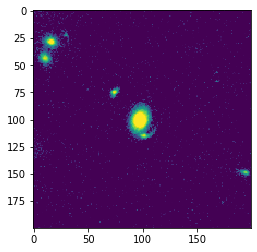

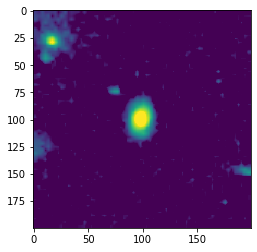

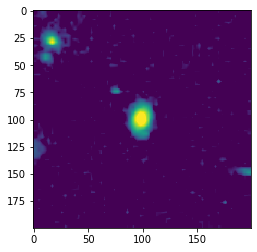

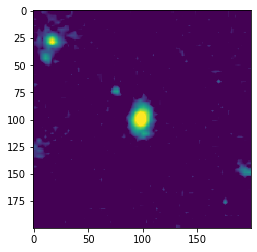

In [250]:
img = build_image(270210, TRAIN)
for i in range(4):
    print(np.min(img[:,:,i]), np.max(img[:,:,i]))
    plt.figure()
    a = plt.imshow((img[:,:,i]))

In [232]:
def save_img_dataset(id_list, set_, outpath='.'):
    for id_ in id_list:
        image = build_image(id, set_)
        tifffile.imsave(os.path.join(outpath, 'image_%i_allbands.tiff'%id_))
        